In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as sns; sns.set(font_scale=1.5)  # plot formatting

In [2]:
import pandas as pd
counts = pd.read_csv('./data/FremontBridge.csv', index_col='Date', parse_dates=True)

In [122]:
weather = pd.read_csv('./data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

# Source of weather data:
# http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND
# Weather station: USW00024233

In [123]:
print(weather.columns)

Index(['STATION', 'NAME', 'AWND', 'AWND_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES',
       'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD',
       'SNWD_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES',
       'TMIN', 'TMIN_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES', 'WDF5',
       'WDF5_ATTRIBUTES', 'WSF2', 'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES',
       'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03',
       'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES',
       'WT08', 'WT08_ATTRIBUTES', 'WT09', 'WT09_ATTRIBUTES', 'WT13',
       'WT13_ATTRIBUTES', 'WT14', 'WT14_ATTRIBUTES', 'WT16', 'WT16_ATTRIBUTES',
       'WT18', 'WT18_ATTRIBUTES', 'WT22', 'WT22_ATTRIBUTES'],
      dtype='object')


# From documentation
[./data/Weather_documentation.pdf](./data/Weather_documentation.pdf)

Missing data: 9's (e.g. 9999)

> Not sure how the flags work – let us forget about those for the moment

In [124]:
cols = weather.columns
weather = weather[cols[~cols.str.endswith('ATTRIBUTES')]]

What about the other columns?

- PRCP = Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)
- SNOW = Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)
- SNWD = Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)
- TMAX = Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file)
- TMIN = Minimum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file)
- AWND = Average daily wind speed (meters per second or miles per hour as per user preference)
- PGTM = Peak gust time (hours and minutes, i.e., HHMM)


- WDF2 = Direction of fastest 2-minute wind (degrees)
- WDF5 = Direction of fastest 5-second wind (degrees)


- WSF2 = Fastest 2-minute wind speed (miles per hour or meters per second as per user preference) 
- WSF5 = Fastest 5-second wind speed (miles per hour or meters per second as per user preference)


- WTxx = Weather Type where xx has one of the following values:
    - 01 = Fog, ice fog, or freezing fog (may include heavy fog) 
    - 02 = Heavy fog or heaving freezing fog (not always distinguished from fog) 
    - 03 = Thunder
    - 04 = Ice pellets, sleet, snow pellets, or small hail
    - 05 = Hail (may include small hail)
    - 06 = Glaze or rime
    - 07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction 
    - 08 = Smoke or haze
    - 09 = Blowing or drifting snow
    - 10 = Tornado, waterspout, or funnel cloud
    - 11 = High or damaging winds
    - 12 = Blowing spray
    - 13 = Mist
    - 14 = Drizzle
    - 15 = Freezing drizzle
    - 16 = Rain (may include freezing rain, drizzle, and freezing drizzle) 
    - 17 = Freezing rain
    - 18 = Snow, snow pellets, snow grains, or ice crystals
    - 19 = Unknown source of precipitation
    - 21 = Ground fog
    - 22 = Ice fog or freezing fog

All weather types are bad for biking. Let's create a single flag that marks them all!



In [125]:
cols = weather.columns
df = (~weather[cols[cols.str.contains('(^WT)')]].isna()).astype(int)

/Users/koppelman/opt/anaconda3/envs/gold/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [126]:
weather['bad weather'] = df.eval('+'.join(df.columns.values)+'!=0').astype(int)

In [127]:
m2 = weather.columns.str.contains('(^(?!W[STD]))')
weather[weather.columns[~m2]].isna().sum()/weather.shape[0]

/Users/koppelman/opt/anaconda3/envs/gold/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


WDF2    0.000000
WDF5    0.010536
WSF2    0.000000
WSF5    0.010536
WT01    0.549170
WT02    0.947318
WT03    0.991699
WT04    0.998404
WT05    0.998723
WT08    0.944125
WT09    0.999681
WT13    0.966794
WT14    0.993934
WT16    0.958812
WT18    0.998084
WT22    0.997126
dtype: float64

In [128]:
# Dropping some final columns
weather = weather[weather.columns[m2]].drop(['STATION','NAME','PGTM'], axis='columns')

In [129]:
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

In [130]:
def fill_TAVG():
    weather['TAVG'] = weather['TAVG'].fillna(value = weather.eval('(TMAX+TMIN)/2'))
    

In [131]:
fill_TAVG()

In [132]:
weather[['SNWD']] = weather[['SNWD']].fillna(value=0)

In [133]:
weather.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,bad weather,dry day
count,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,3.431545,2.993295,0.447957,0.691252,11.925846,16.305396,8.122286,0.486271,0.562580
std,1.386717,6.656352,6.999761,8.994985,5.873073,7.322159,5.015547,0.499891,0.496148
min,0.400000,0.000000,0.000000,0.000000,-4.400000,-1.600000,-7.100000,0.000000,0.000000
25%,2.500000,0.000000,0.000000,0.000000,7.400000,10.600000,4.400000,0.000000,0.000000
50%,3.200000,0.000000,0.000000,0.000000,11.400000,15.000000,8.300000,0.000000,1.000000
75%,4.300000,2.800000,0.000000,0.000000,16.600000,21.700000,12.200000,1.000000,1.000000
max,9.500000,82.600000,226.000000,180.000000,27.600000,36.700000,20.600000,1.000000,1.000000


In [134]:
from sklearn.preprocessing import OneHotEncoder

In [135]:
daily = counts[['Fremont Bridge Total']].resample('d').sum()

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [136]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

In [137]:

holidays = cal.holidays(start='2012', end=None)
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [138]:
weekly = weather.resample('W').mean()

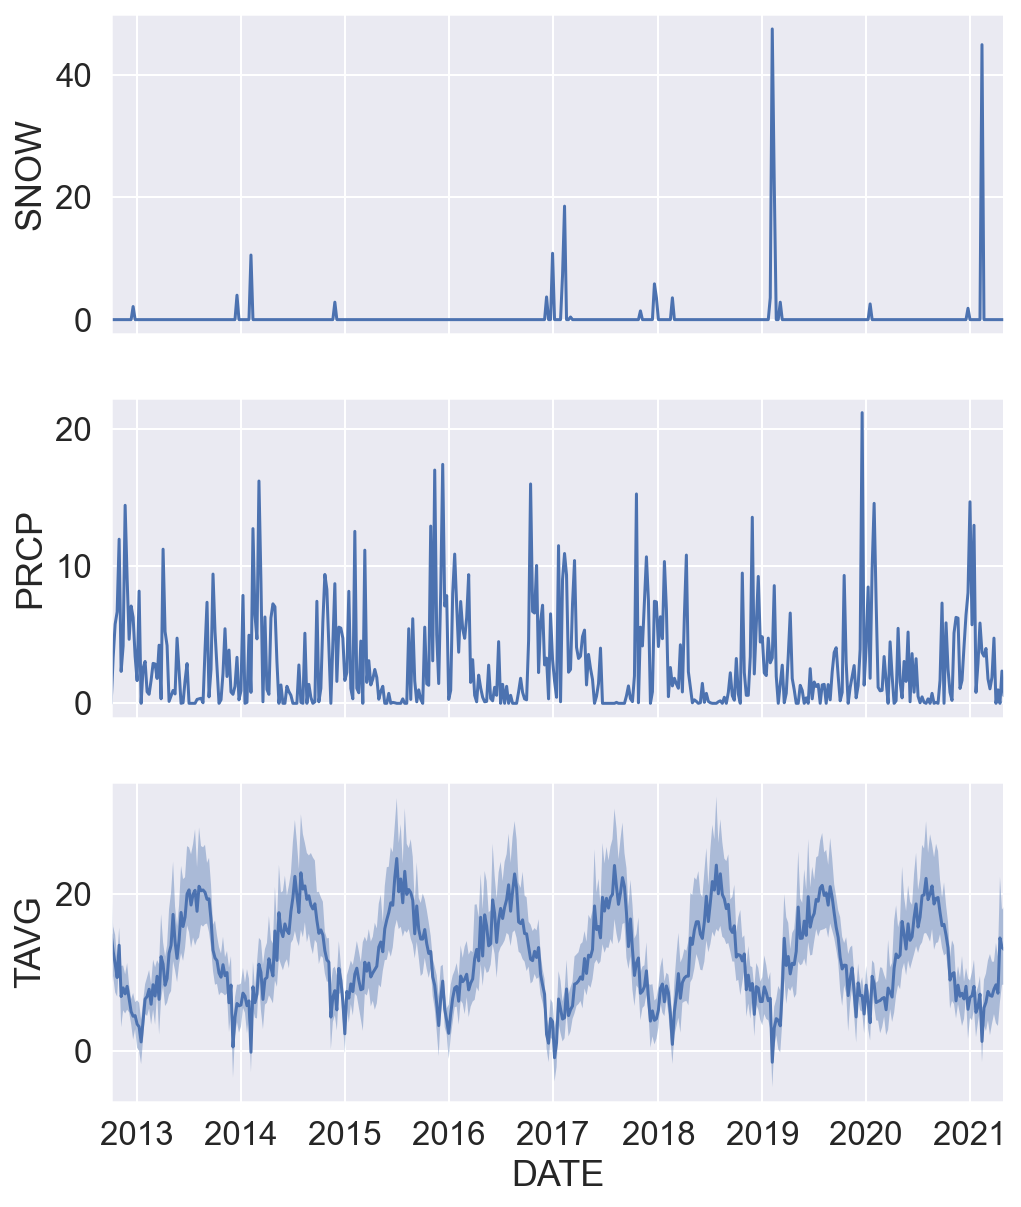

In [139]:
fig, axes = plt.subplots(nrows=3, figsize=(8,10), sharex=True)

weekly['SNOW'].plot(ax = axes[0], ylabel='SNOW')
weekly['PRCP'].plot(ax = axes[1], ylabel='PRCP')
weekly['TAVG'].plot(ax = axes[2], ylabel='TAVG')
plt.fill_between(weekly.index.date, weekly.TMAX, weekly.TMIN, alpha=0.4, edgecolor='none')

plt.show()

/Users/koppelman/opt/anaconda3/envs/gold/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(8.0, 17.0)

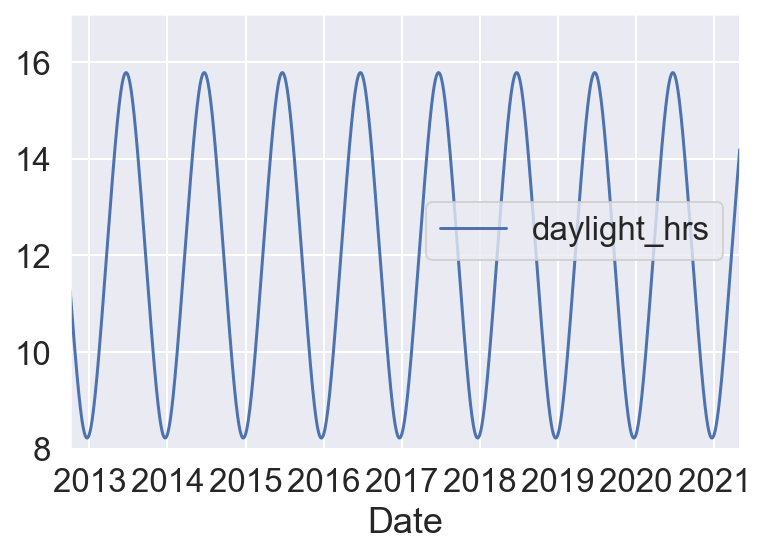

In [140]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [141]:
daily = daily.join(weather[['PRCP', 'TAVG', 'dry day', 'bad weather']])

In [142]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [143]:
daily.rename(columns={"Fremont Bridge Total": "Total", "TAVG": "Temp"}, inplace=True)

In [144]:
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp,dry day,bad weather,annual
Date,,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1,0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1,0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1,0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1,0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1,0,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2411.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.980697,0.0,11.20,1,0,8.567123
2021-04-27,2242.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.033671,0.0,11.50,1,0,8.569863
2021-04-28,2382.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.086250,0.0,12.70,1,0,8.572603


In [146]:
# Checking if any nan's left
daily.isna().sum()

Total           0
Mon             0
Tue             0
Wed             0
Thu             0
Fri             0
Sat             0
Sun             0
holiday         0
daylight_hrs    0
PRCP            0
Temp            0
dry day         0
bad weather     0
annual          0
dtype: int64

In [151]:
from sklearn.linear_model import LinearRegression

column_names = daily.columns[1:]
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

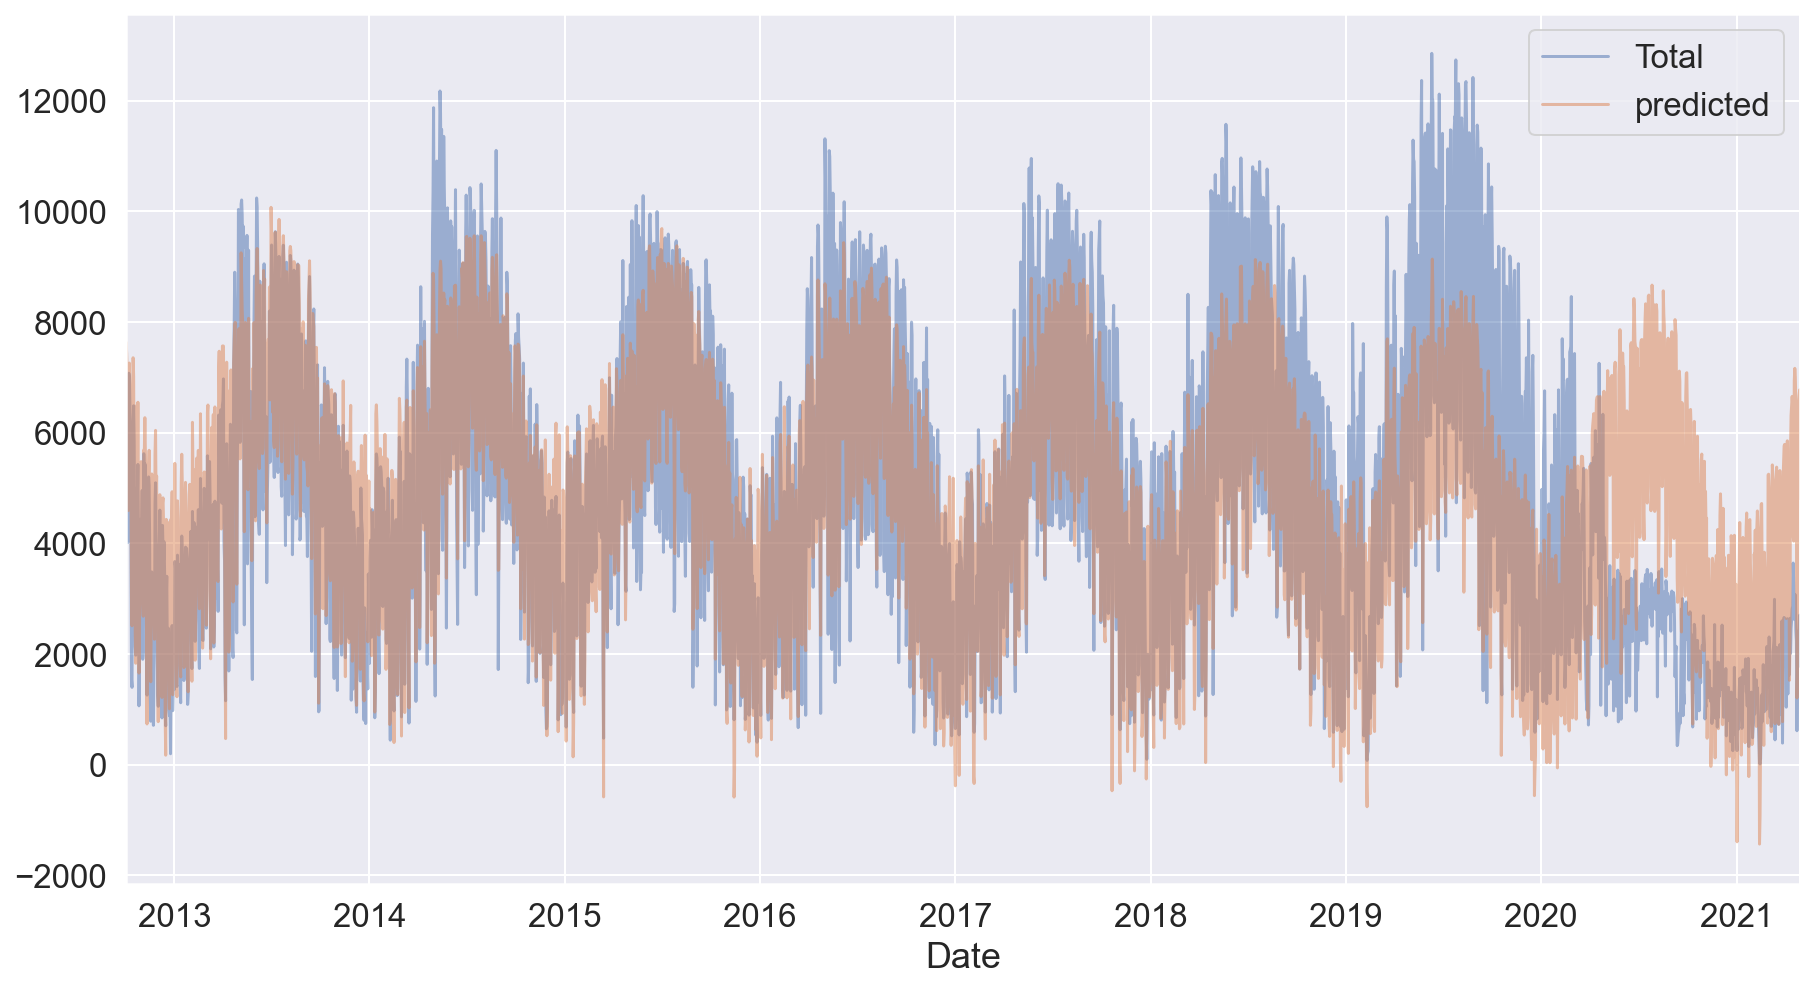

In [154]:
daily[['Total', 'predicted']].plot(alpha=0.5, figsize=(15,8));


In [160]:
params = pd.Series(model.coef_, index=X.columns)
params.sort_values(ascending=False)

Tue             2714.153371
Wed             2681.184791
Mon             2539.407194
Thu             2448.487892
Fri             1861.727854
dry day          915.251954
daylight_hrs     182.497700
Temp             148.228471
PRCP             -50.388384
annual          -160.820742
bad weather     -216.194311
Sat             -531.794290
Sun             -686.578152
holiday        -2230.812560
dtype: float64

### Estimating errors from bootstrapping the input data

In [161]:
from sklearn.utils import resample

np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [163]:
params_werr = pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)})

In [164]:
print(params_werr.sort_values('effect', ascending=False))

              effect  error
Tue           2714.0  198.0
Wed           2681.0  196.0
Mon           2539.0  202.0
Thu           2448.0  194.0
Fri           1862.0  197.0
dry day        915.0   83.0
daylight_hrs   182.0   19.0
Temp           148.0    8.0
PRCP           -50.0    4.0
annual        -161.0   15.0
bad weather   -216.0   83.0
Sat           -532.0  195.0
Sun           -687.0  198.0
holiday      -2231.0  190.0


> We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays. We see that for each additional hour of daylight, 129 ± 9 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each inch of precipitation means 665 ± 62 more people leave their bike at home. Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.

**NB**: numbers have changed wrt the example in the handbook.

### Fitting to non-covid only

In [227]:
daily_preCov19 = daily[:'2019'].drop(columns=['predicted'])


column_names = daily_preCov19.columns[1:]
X = daily_preCov19[column_names]
y = daily_preCov19['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily_preCov19['predicted'] = model.predict(X)

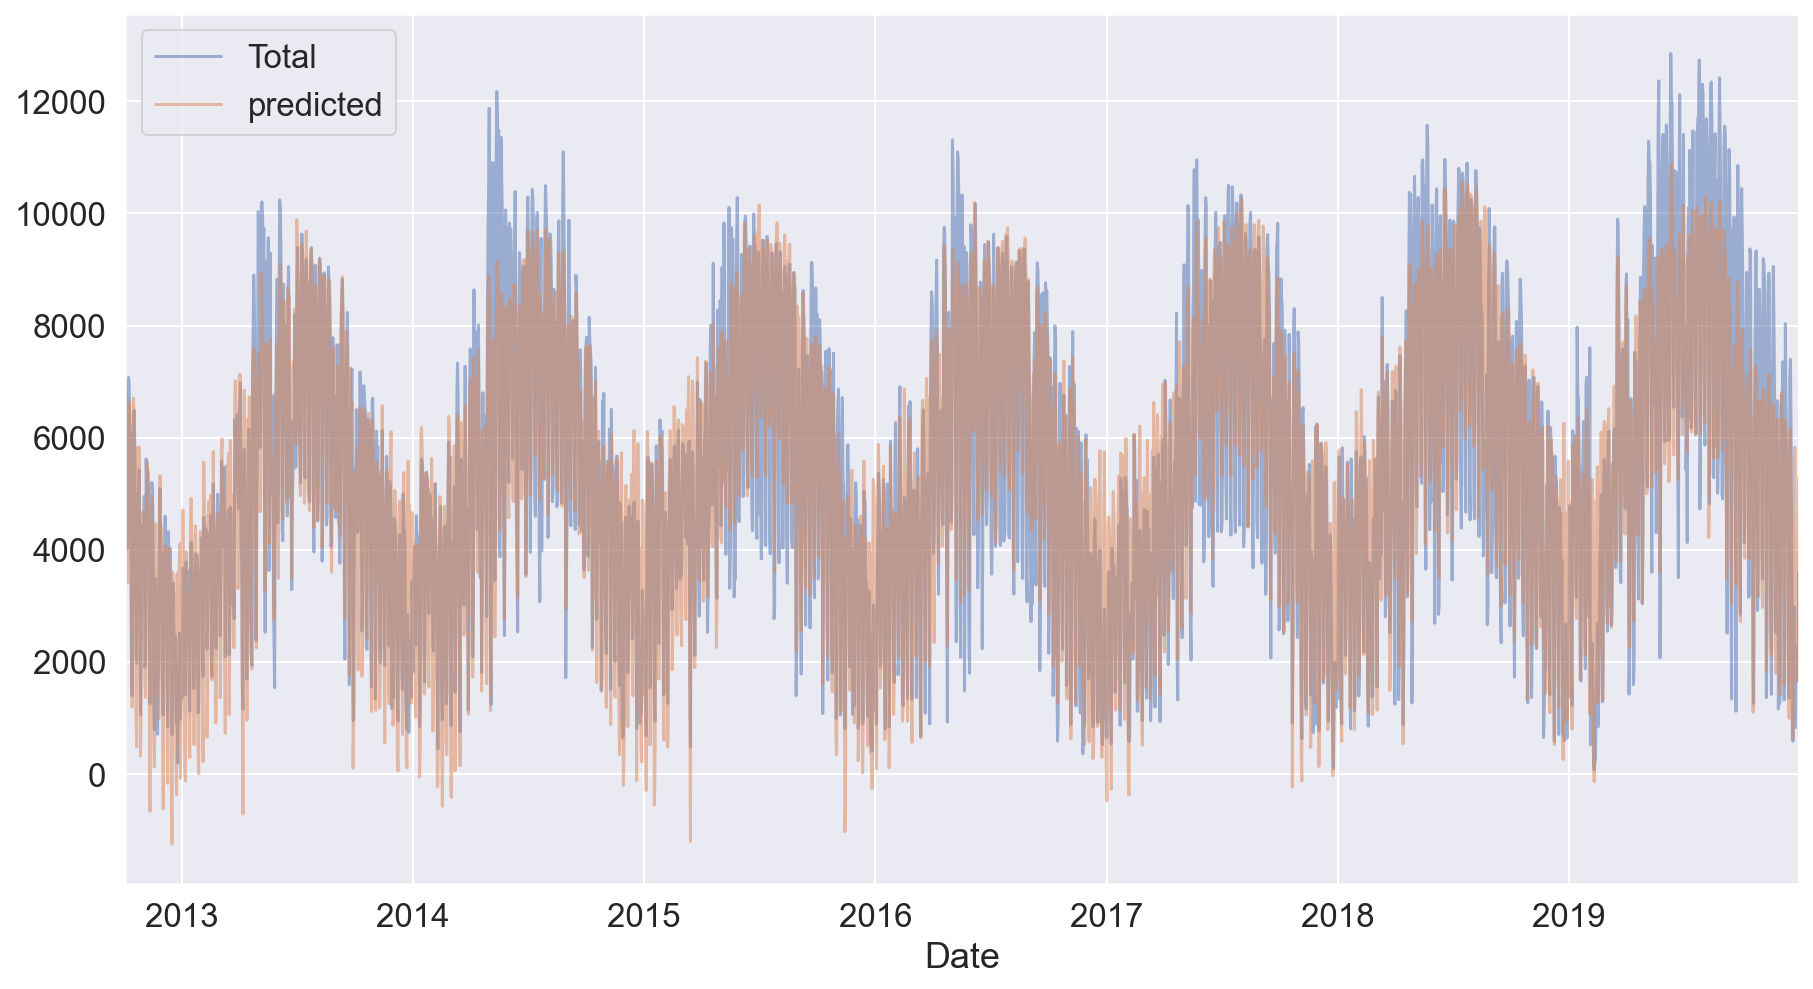

In [228]:
daily_preCov19[['Total', 'predicted']].plot(alpha=0.5, figsize=(15,8));


In [233]:
    
params = pd.Series(model.coef_, index=X.columns)
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)
params_werr = pd.DataFrame({'effect': params.round(0),
                'error': err.round(0)}).sort_values('effect', ascending=False)

In [234]:
print(params_werr)

              effect  error
Tue           1514.0  137.0
Wed           1463.0  134.0
Mon           1309.0  134.0
Thu           1214.0  136.0
dry day       1014.0   59.0
Fri            518.0  138.0
daylight_hrs   217.0   13.0
annual         165.0   11.0
Temp           155.0    6.0
PRCP           -53.0    4.0
bad weather   -199.0   59.0
Sat          -2272.0  138.0
Sun          -2456.0  138.0
holiday      -2505.0  204.0


### Trying polynomial input features

In [238]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
# Constructing the pipeline



column_names = daily.drop(columns=['predicted']).columns[1:]
X = daily[column_names]
y = daily['Total']

model = make_pipeline(PolynomialFeatures(degree=3),
                      LinearRegression(fit_intercept=False))
model.fit(X, y)
daily['predicted'] = model.predict(X)

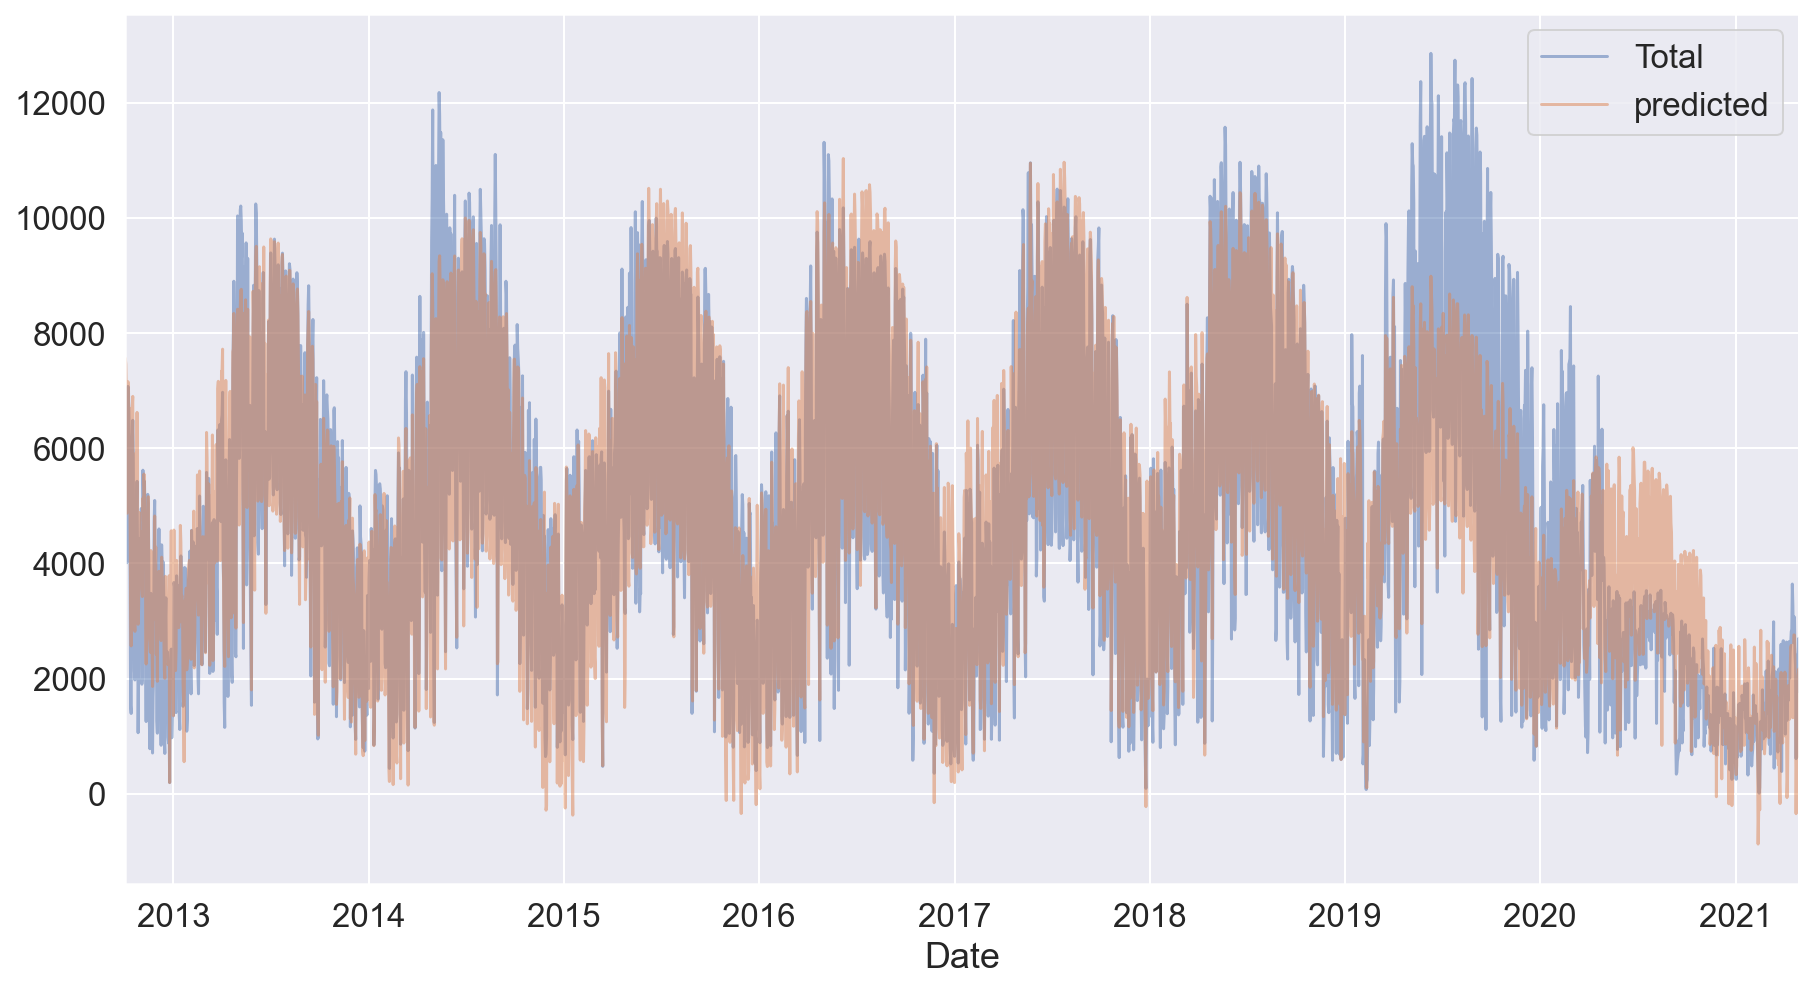

In [239]:
daily[['Total', 'predicted']].plot(alpha=0.5, figsize=(15,8));


### flagging covid

In [270]:
daily.eval('cov = 1*(index > "March 2020")', inplace=True)

In [271]:
column_names = daily.drop(columns=['predicted']).columns[1:]
X = daily[column_names]
y = daily['Total']

model = make_pipeline(PolynomialFeatures(degree=2),
                      LinearRegression(fit_intercept=False))
model.fit(X, y)
daily['predicted'] = model.predict(X)

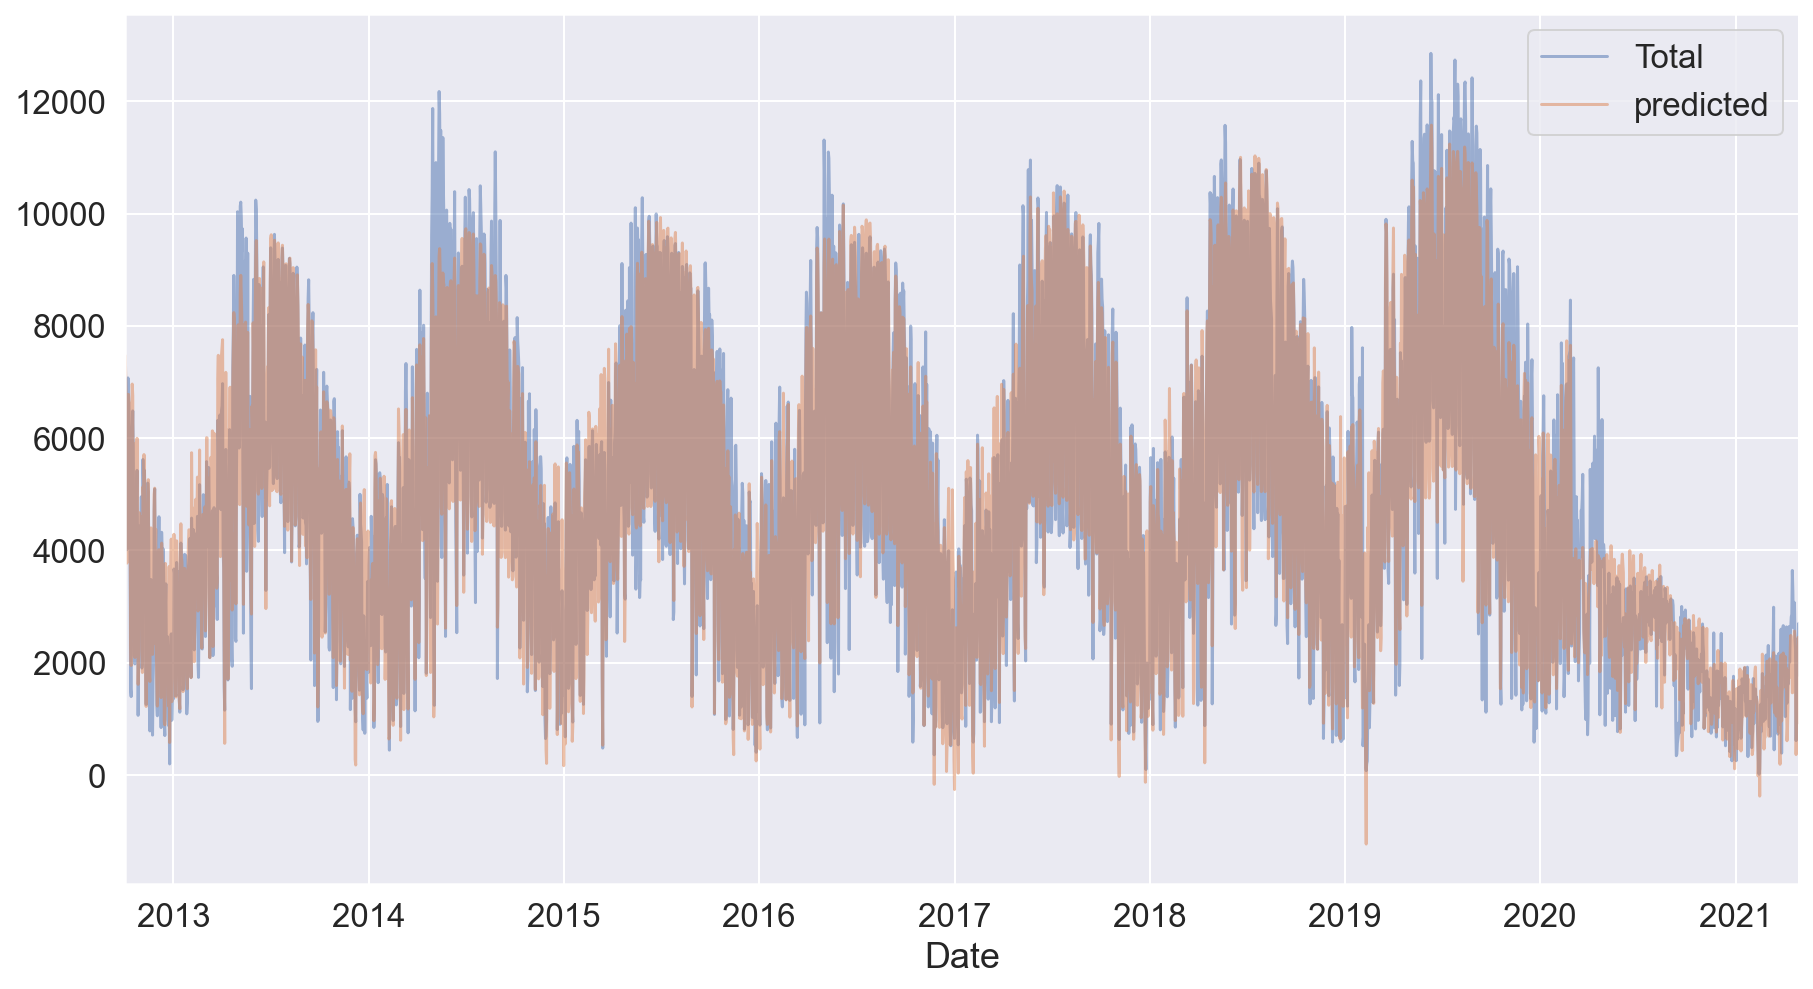

In [272]:
daily[['Total', 'predicted']].plot(alpha=0.5, figsize=(15,8));


Second degree polynomial with covid flags works quite well!